In [1]:
!git clone https://github.com/herm23/Project-NNDL.git

Cloning into 'Project-NNDL'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 39 (delta 6), reused 35 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 2.65 MiB | 2.32 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
%cd Project-NNDL/

/content/Project-NNDL


Link per il datset di CompCar (trovato su sito ufficiale): https://drive.google.com/drive/folders/18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg


In [3]:
!pip install -U -q PyDrive

Import necessari

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

Scarico i dati direttamente dal drive pubblico

In [5]:
#Autenticazione
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Estrazione dei dati dalla cartella
# ID della cartella pubblica
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'

# Cartella locale per salvare i dati
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)

# Lista file nella cartella Drive
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Scarica tutti i file
for file in file_list:
    print(f"Scaricando {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))



Scaricando sv_data.zip
Scaricando sv_data.z03
Scaricando sv_data.z02
Scaricando sv_data.z01
Scaricando data.zip
Scaricando data.z22
Scaricando data.z21
Scaricando data.z20
Scaricando data.z19
Scaricando data.z18
Scaricando data.z17
Scaricando data.z16
Scaricando data.z15
Scaricando data.z14
Scaricando data.z13
Scaricando data.z12
Scaricando data.z11
Scaricando data.z10
Scaricando data.z09
Scaricando data.z08
Scaricando data.z07
Scaricando data.z06
Scaricando data.z05
Scaricando data.z04
Scaricando data.z03
Scaricando data.z02
Scaricando data.z01
Scaricando README.txt


In [7]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
%cd /content/Project-NNDL/compcar_dataset

/content/Project-NNDL/compcar_dataset


password per unzippare: d89551fd190e38

In [9]:
!7z x data.zip -o./compcar_dataset/unzipped


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 391417395 bytes (374 MiB)

Extracting archive: data.zip
  1% 4096 Open               89% 294912 Open                --
Path = data.zip
Type = zip
Physical Size = 391417395
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 16539487795
Multivolume = +
Volume Index = 22
Volumes = 23

  0%    
Enter password (will not be echoed):
  0% 5 - data/image/1/1101/2011/07b90decb92ba6.jpg                                                    0% 144 - data/image/1/1112/2013/16179e5d599552.jpg                  

dataset

In [26]:
import os
from PIL import Image
from torch.utils.data import Dataset
import scipy.io as sio

class CompCarsSubsetDataset(Dataset):
    def __init__(self, image_root, mat_path, list_txt_path, transform=None, label_type='make'):
        """
        image_root: path alla cartella che contiene le immagini (es. 'data/image/')
        mat_path: path al file 'make_model_name.mat'
        list_txt_path: path al file train.txt o simile con nomi immagini da caricare
        transform: trasformazioni PyTorch
        label_type: 'make' o 'model'
        """
        self.image_root = image_root
        self.transform = transform
        label_type = label_type.lower()
        if label_type not in ['make', 'model']:
            raise ValueError("label_type deve essere 'make' o 'model'")
        self.label_type = label_type
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Carica i nomi da .mat
        mat = sio.loadmat(mat_path)

        # Carica nomi e id da .mat per make o model
        if self.label_type == "make":
            names = [name[0] for name in mat['make_names'][:, 0]]
            id_to_name = {i+1: names[i] for i in range(len(names))}
            # Qui il mapping id->name per le make_id nel nome file
        elif self.label_type == "model":
            names = [name[0] for name in mat['model_names'][:, 0] if len(name) > 0]
            id_to_name = {i+1: names[i] for i in range(len(names))}

        # Costruisci dizionari label ↔ indice numerico (da 0 a C-1)
        for idx, name in enumerate(sorted(set(names))):
            self.class_to_idx[name] = idx
            self.idx_to_class[idx] = name

        # Leggi lista immagini da file txt (es. train.txt)
        with open(list_txt_path, 'r') as f:
            img_names = f.read().splitlines()

        # Costruisci lista (path_immagine, label) solo per quelle immagini in img_names
        for img_name in img_names:
            img_path = os.path.join(image_root, img_name)

            # Estrapola l'id da img_name per recuperare label:
            # Assumendo che img_name sia tipo: "make_id/model_id/xxx.jpg" o "make_id/xxx.jpg"
            # oppure "make_id_model_id_xxx.jpg", adatta in base al formato reale
            parts = img_name.split('/')

            if self.label_type == 'make':
                # Prendi make_id dalla prima parte (es. '0123/...')
                make_id = int(parts[0])
                if make_id not in id_to_name:
                    continue
                label_name = id_to_name[make_id]
            else:
                # model: prendi modello da seconda parte (es. 'make_id/model_id/xxx.jpg')
                if len(parts) < 2:
                    continue
                model_id = int(parts[1])
                if model_id not in id_to_name:
                    continue
                label_name = id_to_name[model_id]

            label = self.class_to_idx[label_name]
            self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [27]:
from torchvision.transforms import transforms, ToTensor
import torch

image_root = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
mat_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'
list_txt_path_train = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/train_test_split/classification/train.txt'
list_txt_path_test = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/train_test_split/classification/test.txt'

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = CompCarsSubsetDataset(image_root, mat_path, list_txt_path_train, transform=transform, label_type='make')
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataset = CompCarsSubsetDataset(image_root, mat_path, list_txt_path_test, transform=transform, label_type='make')
#test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [28]:
print(len(train_dataset))
print(len(test_dataset))

16016
14939


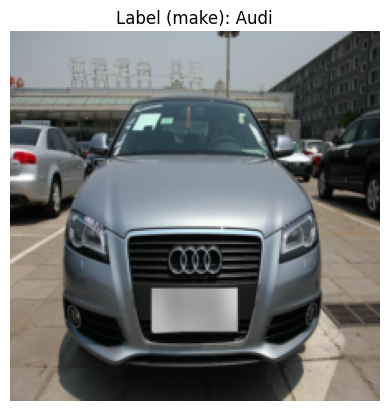

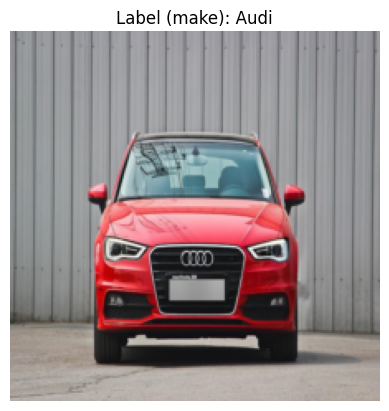

In [29]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]
img1, label1 = test_dataset[0]

plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f"Label (make): {train_dataset.idx_to_class[label]}")
plt.axis('off')
plt.show()

plt.imshow(img1.permute(1, 2, 0).numpy())
plt.title(f"Label (make): {test_dataset.idx_to_class[label1]}")
plt.axis('off')
plt.show()

# CNN

In [30]:
from torchvision.transforms import transforms, ToTensor
import torchvision
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

NUM_WORKERS = os.cpu_count()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# path
img = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
maker_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'

Device: cuda:0
Number of workers: 12


Rete formata da encoder=ResNet34 e trasformhead=2 linear layers

In [31]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d, AdaptiveAvgPool2d, Linear, Dropout

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[1], kernel_size=1, stride=2),
            BatchNorm2d(filters[1])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

class ResNet34(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2, padding=1),
            ConvolutionalBlock(64, [64, 64], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(64, [64, 64], kernel_size=3),
            IdentityBlock(64, [64, 64], kernel_size=3),
            ConvolutionalBlock(64, [128, 128], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(128, [128, 128], kernel_size=3),
            IdentityBlock(128, [128, 128], kernel_size=3),
            IdentityBlock(128, [128, 128], kernel_size=3),
            ConvolutionalBlock(128, [256, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            IdentityBlock(256, [256, 256], kernel_size=3),
            ConvolutionalBlock(256, [512, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [512, 512], kernel_size=3),
            IdentityBlock(512, [512, 512], kernel_size=3),
            AdaptiveAvgPool2d((1, 1))
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

class Classifier_Make(Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
                          nn.Linear(feature_dim, 256),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(256, num_classes)
                      )

    def forward(self, x):
        return self.classifier(x)

class SimCLR(Module):
    def __init__(self):
        super().__init__()
        self.convnet = ResNet34()
        self.classifier = Classifier_Make(512, num_classes=163)

    def forward(self, x):
        return self.classifier(self.convnet(x))

train

In [32]:
import torch
import torch.nn as nn
import numpy as np

def train(model, device, train_loader, optimizer, lr_scheduler, epoch, maxit=float('inf')):
    train_losses = []
    accs = []
    criterion = nn.CrossEntropyLoss()

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        feats, labels = batch
        feats = feats.to(device)
        labels = labels.to(device)

        # Forward pass
        preds = model(feats)

        # Compute the cross entropy loss
        loss = criterion(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        train_losses.append(loss.item())
        accs.append(acc.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Train Epoch: {epoch}, Iteration: {i}/{len(train_loader)},  \tLoss: {loss.item():.6f}, \tAcc: {acc.item():.6f}")

        if i >= maxit:
            return np.mean(train_losses), np.mean(accs)
            break

    lr_scheduler.step()
    return np.mean(train_losses), np.mean(accs)

In [33]:
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from google.colab import drive
drive.mount('/content/drive')

# Define training hyperparameters
weight_decay=1e-4
batch_size = 256
max_epochs=500
lr=2e-4

epochs = 100
maxit = float('inf')

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define the simple classifier model
model = SimCLR()
model.to(device)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

checkpoint_dir = "/content/drive/MyDrive/NNDL/progetto/classifierNN"

for epoch in range(epochs):
    train_loss, train_acc = train(model, device, train_dataloader,
                                  optimizer, lr_scheduler, epoch, maxit=maxit)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")

    # Salva modello ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))
        print(f"Saved model checkpoint at epoch {epoch+1}")

# Alla fine dell’ultimo epoch salva checkpoint completo
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
}
torch.save(checkpoint, os.path.join(checkpoint_dir, f'model_final_epoch_{epochs}.pth'))
print(f"Saved final model checkpoint at epoch {epochs}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Epoch: 0, Iteration: 0/63,  	Loss: 5.133764, 	Acc: 0.000000
Train Epoch: 0, Iteration: 1/63,  	Loss: 5.108286, 	Acc: 0.015625
Train Epoch: 0, Iteration: 2/63,  	Loss: 5.019427, 	Acc: 0.027344
Train Epoch: 0, Iteration: 3/63,  	Loss: 4.913960, 	Acc: 0.066406
Train Epoch: 0, Iteration: 4/63,  	Loss: 4.889896, 	Acc: 0.058594
Train Epoch: 0, Iteration: 5/63,  	Loss: 4.780704, 	Acc: 0.093750
Train Epoch: 0, Iteration: 6/63,  	Loss: 4.805538, 	Acc: 0.046875
Train Epoch: 0, Iteration: 7/63,  	Loss: 4.691442, 	Acc: 0.085938
Train Epoch: 0, Iteration: 8/63,  	Loss: 4.638187, 	Acc: 0.085938
Train Epoch: 0, Iteration: 9/63,  	Loss: 4.594942, 	Acc: 0.070312
Train Epoch: 0, Iteration: 10/63,  	Loss: 4.677348, 	Acc: 0.054688
Train Epoch: 0, Iteration: 11/63,  	Loss: 4.602795, 	Acc: 0.039062
Train Epoch: 0, Iteration: 12/63,  	Loss: 4.473375, 	Acc: 0.078125
Train Epoc

KeyboardInterrupt: 

Results

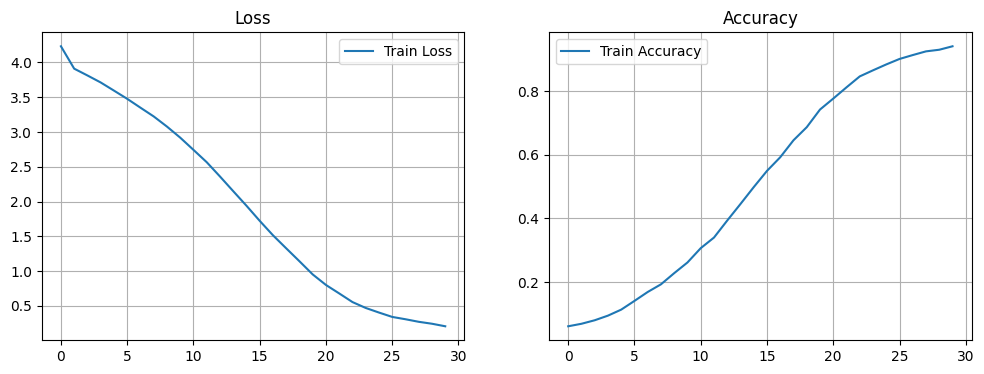

In [34]:
import matplotlib.pyplot as plt
# Let's plot the training and validation losses and Top-5 Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[1].plot(train_accs, label='Train Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

plt.show()

test

In [35]:
import torch
import torch.nn as nn
import numpy as np

def test(model, device, test_loader):
    model.eval()  # modalità evaluation
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    accs = []

    with torch.no_grad():  # niente gradiente
        for batch in test_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)

            preds = model(feats)
            loss = criterion(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            test_losses.append(loss.item())
            accs.append(acc.item())

    avg_loss = np.mean(test_losses)
    avg_acc = np.mean(accs)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc


In [36]:
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

# Define the simple classifier model
model = SimCLR()
model.to(device)

# Carica checkpoint del modello allenato
checkpoint_path = "/content/drive/MyDrive/NNDL/progetto/classifierNN/model_epoch_30.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = test(model, device, test_dataloader)


Test Loss: 3.7549, Test Accuracy: 0.3438
